In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
input_path_i = "results/diti_06_05_kocyk_bez_zabawek/Kamera_1_infant_short.csv"
input_path_a = "results/diti_06_05_kocyk_bez_zabawek/Kamera_2_adult_short.csv"
input_path_a_full = "results/diti_06_05_kocyk_bez_zabawek/Kamera_2_adult.csv"
df_infant = pd.read_csv(input_path_i)
df_adult = pd.read_csv(input_path_a)
df_adult_full = pd.read_csv(input_path_a_full)

In [39]:
# Drop unnecessary columns
df_infant_cr_processed = df_infant.drop("Frame", axis=1)
df_adult_cr_processed = df_adult.drop("Frame", axis=1)
df_adult_cr_full_processed = df_adult_full.filter(like="au", axis=1)

# Drop rows with -1
mask = ~((df_infant == -1) | (df_adult == -1)).any(axis=1)
df_infant_processed = df_infant_cr_processed.loc[mask]
df_adult_processed = df_adult_cr_processed.loc[mask]
df_adult_full_processed = df_adult_cr_full_processed.loc[mask]

AUs = list(df_infant_processed.columns)
print(AUs)

['Occ_au_1', 'Occ_au_2', 'Occ_au_3', 'Occ_au_4', 'Occ_au_6', 'Occ_au_9', 'Occ_au_12', 'Occ_au_20', 'Occ_au_28']


In [29]:
if len(df_adult_processed) > len(df_infant_processed):
    del_cnt = len(df_adult_processed) - len(df_infant_processed)
    df_adult_processed = df_adult_processed.iloc[del_cnt:]
    df_adult_full_processed = df_adult_full_processed.iloc[del_cnt:]

## Correlation

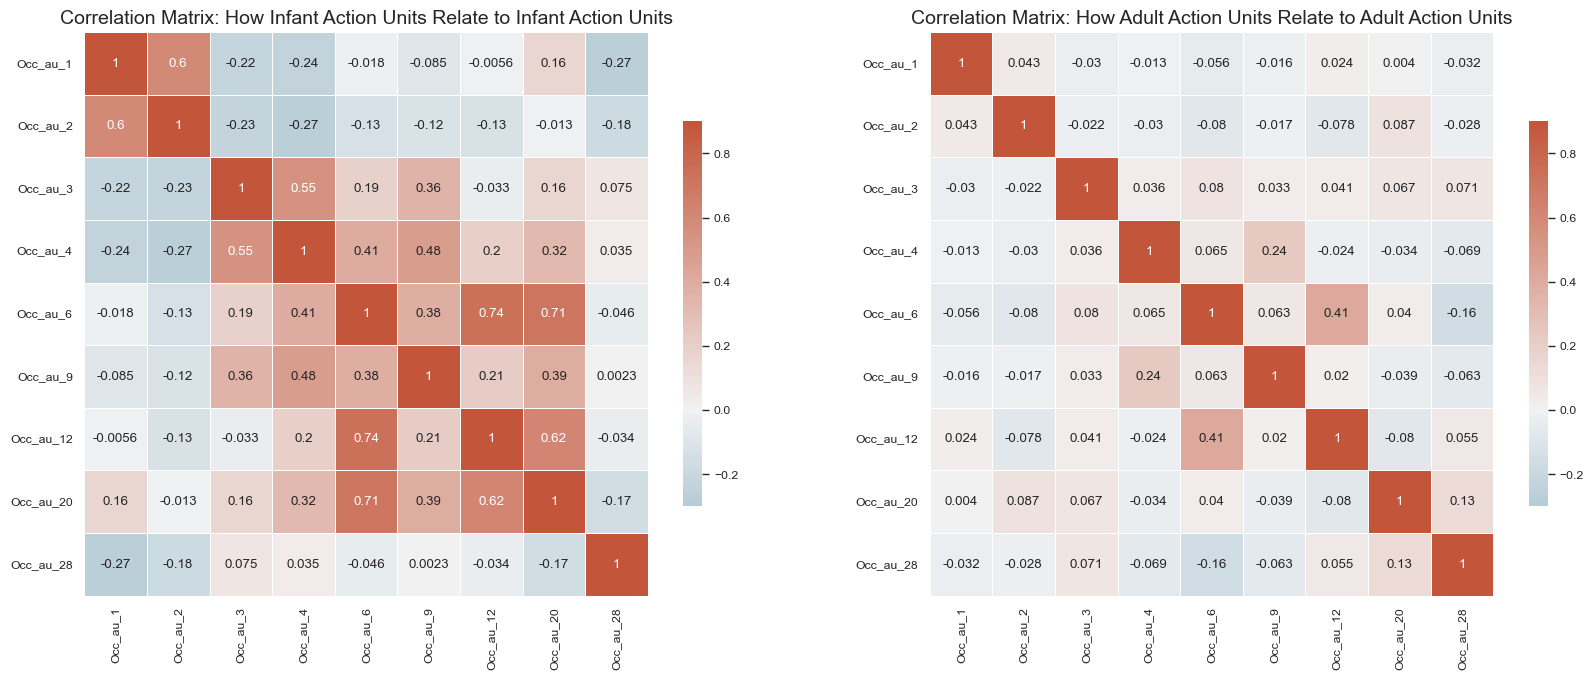

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, (df, name) in enumerate([(df_infant_processed, 'Infant'), (df_adult_processed, 'Adult')]):
    ax = axes[i]
    
    corr = df.corr(numeric_only=True)
    #mask = np.triu(np.ones_like(corr, dtype=bool))
    #mask = np.eye(len(corr), dtype=bool)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=None, cmap=cmap, vmax=.9, vmin=-.3, center=0, ax=ax,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    ax.set_title(f"Correlation Matrix: How {name} Action Units Relate to {name} Action Units", fontsize=14)
plt.show()

## Pearson correlation and RV Coefficient

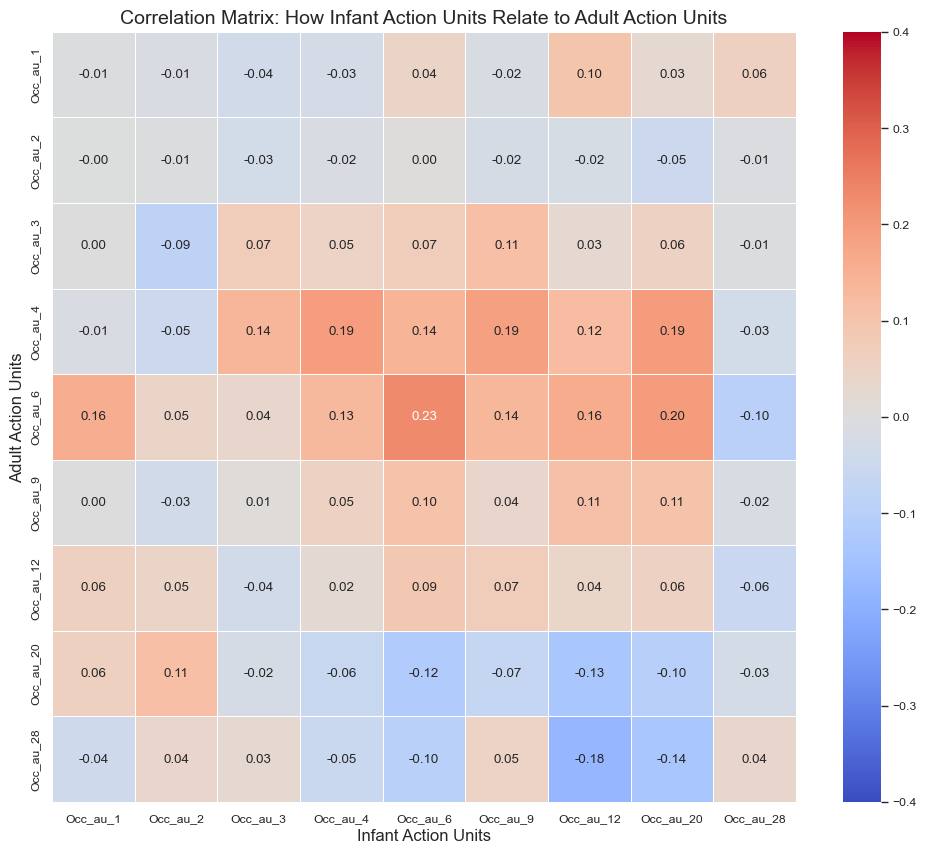

In [31]:
full_corr_matrix = pd.DataFrame(index=df_adult_processed.columns, columns=df_infant_processed.columns)

for col1 in df_adult_processed.columns:
    for col2 in df_infant_processed.columns:
        full_corr_matrix.loc[col1, col2] = df_adult_processed[col1].corr(df_infant_processed[col2])

plt.figure(figsize=(12, 10))
ax = sns.heatmap(full_corr_matrix.astype(float), annot=True, cmap='coolwarm', vmax=.4, vmin=-.4,
                 fmt='.2f', cbar=True, linewidths=0.5)
ax.set_xlabel("Infant Action Units", fontsize=12)
ax.set_ylabel("Adult Action Units", fontsize=12)
ax.set_title("Correlation Matrix: How Infant Action Units Relate to Adult Action Units", fontsize=14)
plt.show()

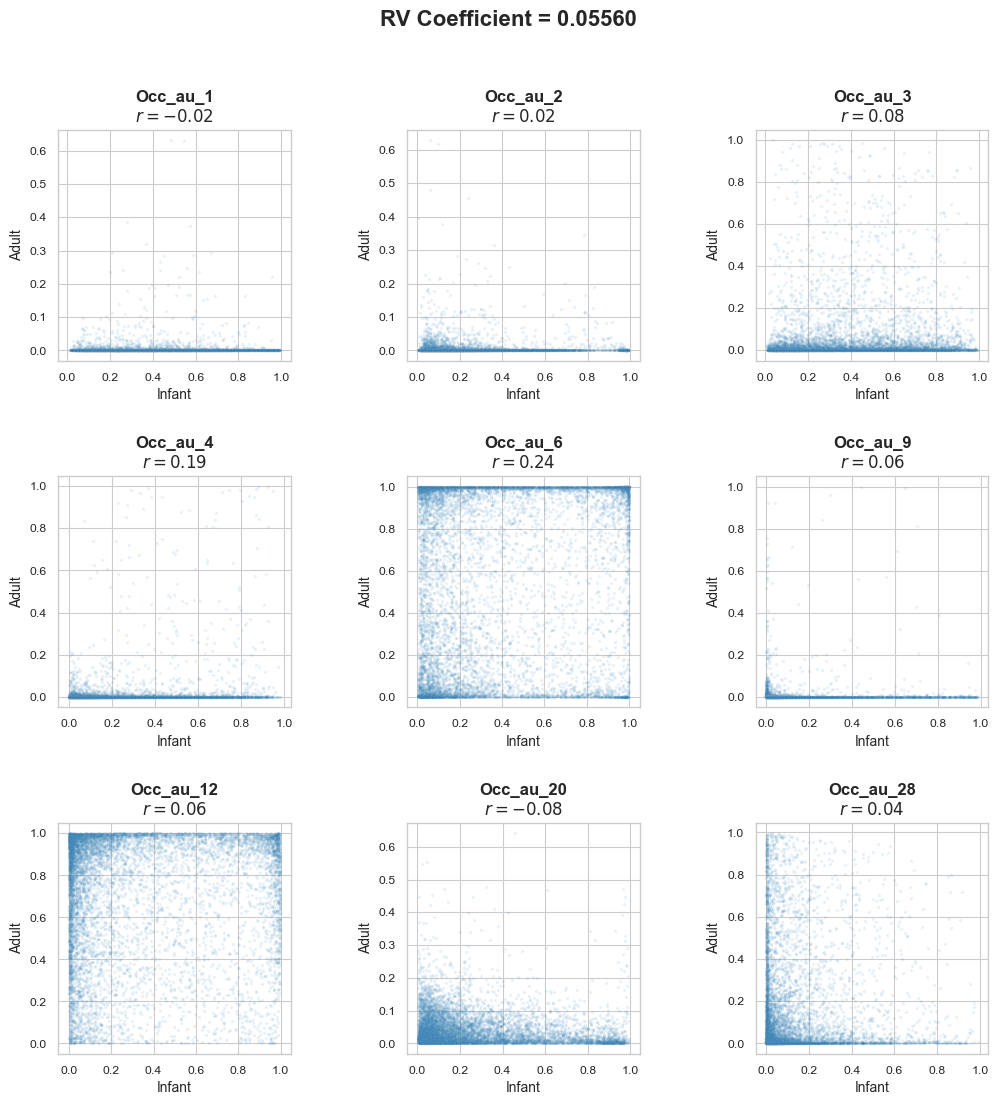

In [32]:
from scipy.stats import pearsonr

def cov(X, Y):
    return np.dot((X - X.mean(axis=0)).T, (Y - Y.mean(axis=0))) / X.shape[0]

def rv_coefficient(X, Y):
    X, Y = X.values, Y.values
    COVV = np.trace(np.dot(cov(X, Y), cov(Y, X)))
    VAV = np.trace(np.dot(cov(X, X), cov(X, X))) * np.trace(np.dot(cov(Y, Y), cov(Y, Y))) 
    return COVV / np.sqrt(VAV)

rv_value = rv_coefficient(df_infant_processed, df_adult_processed)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, au in enumerate(AUs):
    row, col_idx = divmod(i, 3)
    ax = axes[row, col_idx]

    r, _ = pearsonr(df_infant_processed[au], df_adult_processed[au])
    
    sns.set_context("paper")
    sns.set_style("whitegrid")
    sns.scatterplot(
        x=df_infant_processed[au], 
        y=df_adult_processed[au], 
        ax=ax, 
        alpha=0.1,
        s=5,
    )

    ax.set_xlabel(f"Infant", fontsize=10)
    ax.set_ylabel(f"Adult", fontsize=10)
    ax.set_title(f"{au}\n$r = {r:.2f}$", fontsize=12, fontweight="bold")

fig.suptitle(f"RV Coefficient = {rv_value:.5f}", fontsize=16, fontweight="bold")

plt.show()

## Canonical Correlation Analysis

In [33]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=9)
X_c, Y_c = cca.fit_transform(df_infant_processed, df_adult_processed)

# Compute the canonical correlations for each pair of canonical variates
canonical_correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]

print("Canonical Correlations:")
for idx, corr in enumerate(canonical_correlations, 1):
    print(f"Component {idx}: {corr:.3f}")

Canonical Correlations:
Component 1: 0.393
Component 2: 0.240
Component 3: 0.193
Component 4: 0.151
Component 5: 0.104
Component 6: 0.078
Component 7: 0.043
Component 8: 0.022
Component 9: 0.004


In [34]:
# All adult's data

cca = CCA(n_components=9)
X_c, Y_c = cca.fit_transform(df_infant_processed, df_adult_full_processed)

# Compute the canonical correlations for each pair of canonical variates
canonical_correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]

print("Canonical Correlations:")
for idx, corr in enumerate(canonical_correlations, 1):
    print(f"Component {idx}: {corr:.3f}")

Canonical Correlations:
Component 1: 0.486
Component 2: 0.379
Component 3: 0.271
Component 4: 0.204
Component 5: 0.167
Component 6: 0.137
Component 7: 0.109
Component 8: 0.089
Component 9: 0.063


## Partial least squares regression

In [35]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=9)
X_pls, Y_pls = pls.fit_transform(df_infant_processed, df_adult_processed)

# Compute the correlation between each pair of PLS components
pls_correlations = [np.corrcoef(X_pls[:, i], Y_pls[:, i])[0, 1] for i in range(X_pls.shape[1])]

print("Partial Least Squares Component Correlations:")
for idx, corr in enumerate(pls_correlations, 1):
    print(f"Component {idx}: {corr:.3f}")

Partial Least Squares Component Correlations:
Component 1: 0.045
Component 2: 0.058
Component 3: 0.030
Component 4: 0.031
Component 5: 0.036
Component 6: 0.011
Component 7: 0.013
Component 8: 0.026
Component 9: 0.005


In [36]:
# All adult's data

pls = PLSRegression(n_components=9)
X_pls, Y_pls = pls.fit_transform(df_infant_processed, df_adult_full_processed)

# Compute the correlation between each pair of PLS components
pls_correlations = [np.corrcoef(X_pls[:, i], Y_pls[:, i])[0, 1] for i in range(X_pls.shape[1])]

print("Partial Least Squares Component Correlations:")
for idx, corr in enumerate(pls_correlations, 1):
    print(f"Component {idx}: {corr:.3f}")

Partial Least Squares Component Correlations:
Component 1: 0.236
Component 2: 0.298
Component 3: 0.198
Component 4: 0.134
Component 5: 0.102
Component 6: 0.109
Component 7: 0.088
Component 8: 0.085
Component 9: 0.107


## Cross Recurrence Plot

In [41]:
from pyunicorn.timeseries import CrossRecurrencePlot
import math

def plot_cross_recurrence(x, y, metric="euclidean", threshold=None, dim=None, tau=None, recurrence_rate=0.1, ax=None):
    crp = CrossRecurrencePlot(x=x, y=y, dim=dim, tau=tau, recurrence_rate=recurrence_rate, 
                              metric=metric, threshold=threshold)
    
    R_dense = crp.recurrence_matrix().astype(float)
    print(f"Recurrence matrix shape: {R_dense.shape}")
    
    if ax is not None:
        ax.imshow(R_dense, origin="lower", cmap="binary", aspect="auto")
        ax.set_xlabel("Adult Time Index")
        ax.set_ylabel("Infant Time Index")
    else:
        plt.figure(figsize=(8, 8))
        plt.imshow(R_dense, origin="lower", cmap="binary", aspect="auto")
        plt.xlabel("Adult Time Index")
        plt.ylabel("Infant Time Index")
        plt.colorbar(label="Recurrence")
        plt.title(f"Cross-Recurrence Plot")
        plt.show()

def plot_cross_recurrence_separate(x, y, metric="euclidean", threshold=None, dim=None, tau=None, recurrence_rate=0.1):
    columns, rows = 3, math.ceil(len(x.columns) / 3)
    fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))
    axes = axes.flatten()
    
    for i, au in enumerate(x.columns):
        x_feature = x.iloc[:, i].values.reshape(-1, 1)
        y_feature = y.iloc[:, i].values.reshape(-1, 1)

        plot_cross_recurrence(x=x_feature, y=y_feature, metric=metric, threshold=threshold, dim=dim, 
                              tau=tau, recurrence_rate=recurrence_rate,ax=axes[i])
        axes[i].set_title(au)
        
    plt.tight_layout()
    plt.show()

Calculating cross recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (18593, 18598)


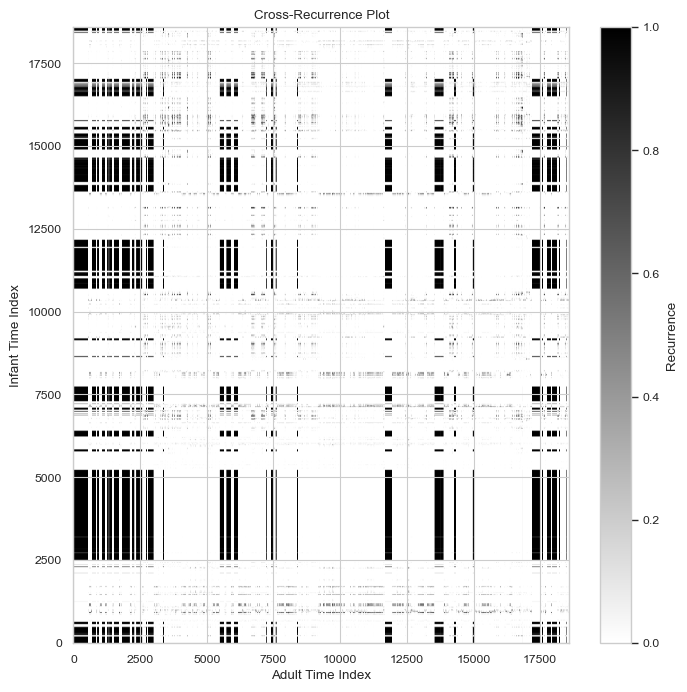

In [42]:
# Everything
plot_cross_recurrence(x=df_infant_cr_processed.values,
                      y=df_adult_cr_processed.values,
                      metric="euclidean", 
                      threshold=0.5, 
                      dim=None, 
                      tau=None,
                      recurrence_rate=None)

Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (18583, 18588)
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (18583, 18588)
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Recurrence matrix shape: (18583, 18588)


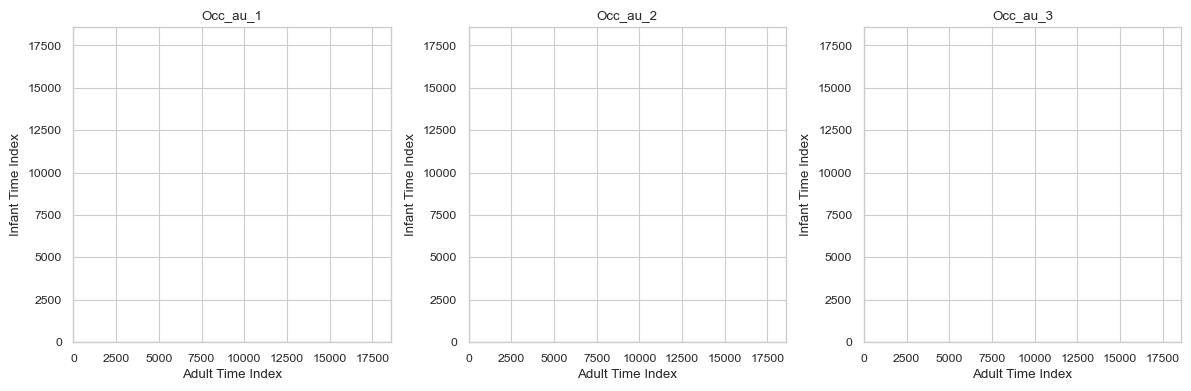

In [43]:
# Separately
plot_cross_recurrence_separate(x=df_infant_cr_processed.iloc[:, :3],
                               y=df_adult_cr_processed.iloc[:, :3],
                               metric="euclidean",
                               threshold=None, 
                               dim=2,
                               tau=10, 
                               recurrence_rate=0.05)